# Interpretability of a decision tree model

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why

## Fit a decision tree model and make global and local explanations

Predict whether a student will dropout from their class.

The workflow is the following:

- Exploratory data analysis
- Identify variables that are good predictors of the target.
- Identify and remove high multi-colinearity among the predictors.
- preprocessing features
- Fit a decision tree model
- Hyperparameter tuning
- Global Interpretation
- Re-train the decision tree
- Local Interpretation

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

import sweetviz as sv
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import re
# pd.set_option('display.max_rows', 10000)

import scipy.stats as ss
from scipy import stats
from scipy.stats.contingency import association
from statsmodels.stats.outliers_influence import variance_inflation_factor
from treeinterpreter import treeinterpreter as ti

from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from feature_engine.selection import SelectBySingleFeaturePerformance

## Load data

In [2]:
train_set = pd.read_csv('datasets/train.csv')
test_set = pd.read_csv('datasets/test.csv')
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory data analysis

This topic we gonna work in an exploration to see what we should do with this data to be able to go to the next steps, readers can skip this step if you are interested just in the model interpretation step.

[Link to the dataset](https://www.kaggle.com/competitions/titanic)

Obs: we don't gonna make an extensive and deep exploratory, because the goal of this notebook is to show how to interpret the models, but in a real project, you should go deeper in the exploration and extract many information as possible.

### Univariate data analysis

For this step, we gonna use a very nice tool to make the things faster that is [sweetviz](https://pypi.org/project/sweetviz/) tool. If you don't know the tool, have a look in the documentation!

In [3]:
my_report = sv.analyze(train_set, 'Survived')
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

Feature: Survived (TARGET)                   |▊         | [  8%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Bivariate Data Analysis

Here we will deal with the descriptive analysis of the **association** between two variables. **In general, we say that there is an association between two variables if knowledge of the value of one of them gives us some information about some characteristic of the distribution (of frequencies) of the other.**

*We can highlight three cases:*

1. both variables are qualitative.
2. both variables are quantitative.
3. one variable is qualitative and the other is quantitative.

#### Two qualitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two qualitative variables.

What are the consequences of multicollinearity?

If two variables are perfectly collinear, in other words, if they have correlation coefficient equal to 1, then what happens is that there is an infinite combination of coefficients (betas) that would work equally well. So basically we have an infinite number of linear regression models that will predict equally well the target from these two perfectly collinear variables. Which means that we are not able to understand what is the real relationship between those variables and the target.

* Perfect collinearity is rare
* Partial collinearity is unavoidable

So what happens is that when we have correlated variables, one of the therms (feature x coefficient) will account for a degree of the variability, and then the other therm basically accounts for the remaining variability that is not explained, but in both cases the coefficient doesn't really represent the real if you want association between the variable and the target.

In [4]:
# select qualitative features
qualitative_features_enconding = [
    'Embarked',
    'Sex'
]

qualitative_binary_passthrough = [
    'Pclass'
]

target = ['Survived']

qualitative_vars = qualitative_features_enconding + qualitative_binary_passthrough + target

In [5]:
# create a dataframe with only categorical variables
categorical_df = train_set[qualitative_vars]

# removing records with at least one null value in a row
df_cat_v1 = categorical_df.dropna()

## let us split this list into two parts
cat_var1 = qualitative_vars
cat_var2 = qualitative_vars

# let us jump to Chi-Square test
# creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1, cat_var2, repeat = 1))

# creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        contingency_table = pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]])
        chi2_pval = ss.chi2_contingency(contingency_table)[1]
        tschuprow_pval = association(contingency_table, method='tschuprow')
        result.append((i[0], i[1], chi2_pval, tschuprow_pval))

# Creating dataframe
result_df = pd.DataFrame(result, columns=['Variable_1', 'Variable_2', 'Chi2_P_Value', 'Tschuprow'])

# let's filter the values with tschuprow coefficient higher than 0.7 to catch multicollinearity
result_df.loc[(result_df['Tschuprow'] >= 0.7)]

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow


We do not have highly related variables, which shows us that we do not have multicollinearity between the qualitative variables. Let's now see the correlation between the variables in relation to the target.

In [6]:
# correlation with the target
result_df.loc[
    (result_df['Variable_1'] == 'Survived')
].sort_values(by=['Tschuprow'])

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow
9,Survived,Embarked,1.769922e-06,0.145153
11,Survived,Pclass,1.181362e-22,0.283407
10,Survived,Sex,3.779910e-58,0.541585


We can see that the variable "Sex" has a strong correlation with the target variable, "Pclass" does not have a very strong correlation and "Embarked" has a weak correlation. Possibly the "Sex" variable will make more of a difference to the predictions than the other two. We'll find out more about this later.

#### Two quantitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two quantitative variables and check multicollinearity.

In [7]:
# select quantitative features
quantitative_features = [
    'Age', 
    'SibSp',
    'Parch',
    'Fare'
]

quantitative_vars = quantitative_features

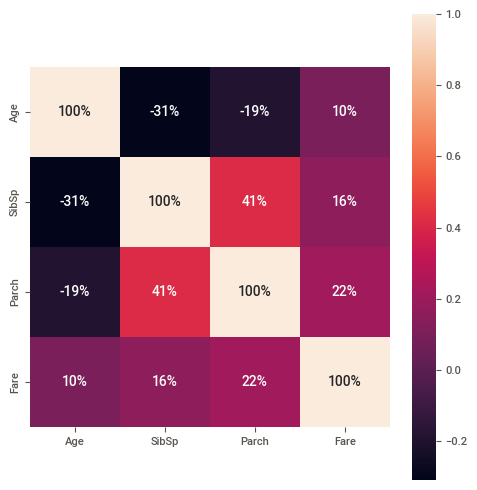

In [8]:
# quantitative associations
quantitative_df = train_set[quantitative_vars]
corr = quantitative_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

In [9]:
# Compute VIF data for each independent variable
clean_quantitative_df = quantitative_df.dropna()
vif = pd.DataFrame()
vif["features"] = clean_quantitative_df.columns
vif["vif_Factor"] = [variance_inflation_factor(clean_quantitative_df.values, i) for i in range(clean_quantitative_df.shape[1])]
vif.sort_values(by=['vif_Factor'], ascending=False, inplace=True)
vif

,features,vif_Factor
3,Fare,1.535595
2,Parch,1.483994
1,SibSp,1.438954
0,Age,1.434323


The variables are not highly correlated, which implies that the presence of multicollinearity will not be an obstacle for us.

#### One qualitative and one quantitative variable

Here the idea is to check the correlation between the qualitative and quantitative variable (the target) to see if the qualitative variables have a high influence in the target.

To find this, we can use visualization methods, statistical measures, Anova or t-test.

In this case, one of the most commonly used hypothesis tests is the t-test, which is used to compare the means of two groups. The t-test is used to determine whether the difference between the means of two groups is statistically significant. Statistical significance refers to the likelihood that the difference between the means is not due to chance. If the difference is statistically significant, it means that there is a high probability that the difference is real and not just due to random variation.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In the specific case of this project, many of the distributions of quantitative variables do not follow a normal distribution, which is a premise of a t-test. In this case, an alternative to the t-test is the Mann-Whitney test, which is a non-parametric test that also compares the median between two groups and does not assume a specific data distribution.

The quantitative variable is: Age
           min   max       mean         var        std
Survived                                              
0         1.00  74.0  30.626179  200.848698  14.172110
1         0.42  80.0  28.343690  223.530965  14.950952


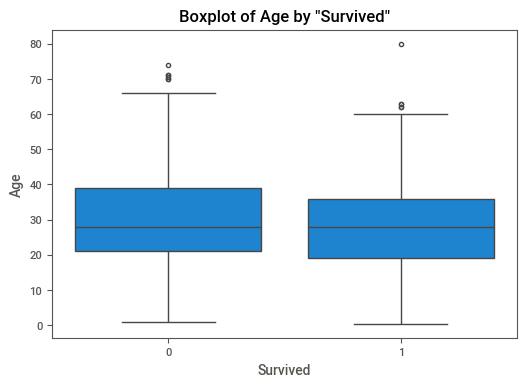

Mann-Whitney U test for Age:
Statistic: nan
P-value: nan
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: SibSp
          min  max      mean       var       std
Survived                                        
0           0    8  0.553734  1.659972  1.288399
1           0    4  0.473684  0.502238  0.708688


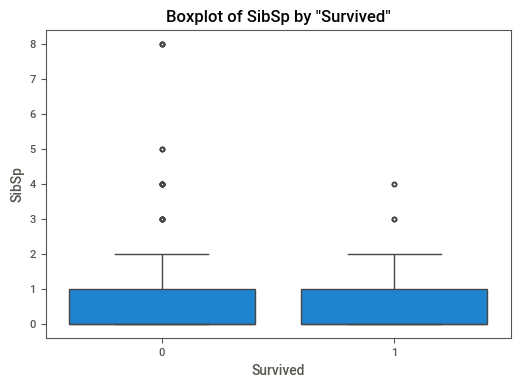

Mann-Whitney U test for SibSp:
Statistic: 101983.0
P-value: 0.008016684059168793
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Parch
          min  max      mean       var       std
Survived                                        
0           0    6  0.329690  0.677602  0.823166
1           0    5  0.464912  0.595539  0.771712


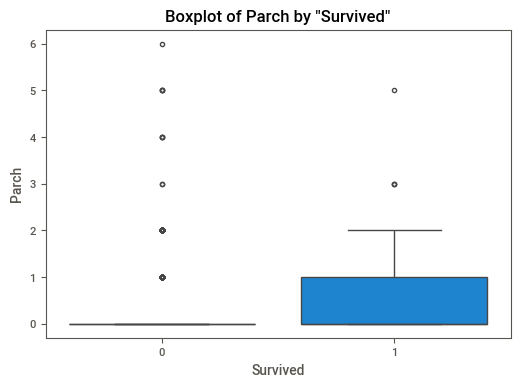

Mann-Whitney U test for Parch:
Statistic: 105373.0
P-value: 3.712490908378456e-05
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Fare
          min       max       mean          var        std
Survived                                                  
0         0.0  263.0000  22.117887   985.219509  31.388207
1         0.0  512.3292  48.395408  4435.160158  66.596998


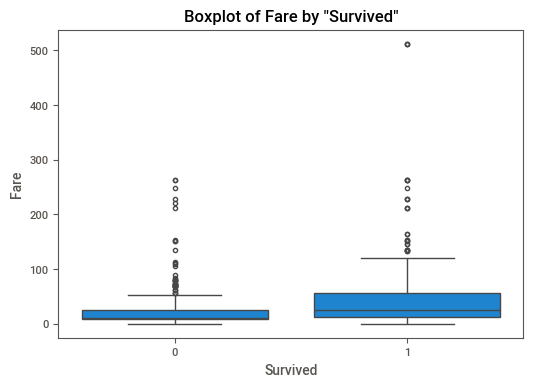

Mann-Whitney U test for Fare:
Statistic: 129951.5
P-value: 4.553477179250237e-22
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------


In [10]:
# visualization and statistical measures approach
# Summary measures for quantitative independent features and label to search for relationships
for var in quantitative_vars:
    print('The quantitative variable is:', var)
    print(train_set.groupby('Survived')[var].agg(['min', 'max', 'mean', 'var', 'std']))
    
    # Create a boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Survived', y=var, data=train_set)
    plt.title(f'Boxplot of {var} by "Survived"')
    plt.xlabel('Survived')
    plt.ylabel(var)
    plt.show()
    
    # Perform the Mann-Whitney U test
    group1 = train_set[train_set['Survived'] == 1][var]
    group2 = train_set[train_set['Survived'] == 0][var]
    statistic, p_value = stats.mannwhitneyu(group1, group2)
    
    # Print the results of the Mann-Whitney U test
    print(f'Mann-Whitney U test for {var}:')
    print(f'Statistic: {statistic}')
    print(f'P-value: {p_value}')
    
    if p_value < 0.05:  # Define an appropriate significance level
        print('There is a statistically significant difference in the medians.')
    else:
        print('There is no statistically significant difference in the medians.')
    
    print('------------------------------------------------------------------------------------------')

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the decision tree model.

In [11]:
# select only the features that we are going to use
X = train_set.drop(['Survived'], axis=1)
y = train_set['Survived']

In [12]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_delete):
        self.columns_to_delete = columns_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_delete, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [feat for feat in input_features if feat not in self.columns_to_delete]

In [13]:
features_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin'
]

In [14]:
qualitative_preproc = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore'))

drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

preprocessor = ColumnTransformer([
    ('features_to_drop', drop_features_preproc, features_to_drop),
    ('qualitative_preproc', qualitative_preproc, qualitative_features_enconding)],
    remainder='passthrough')

## Decision tree

Tree-based models involve segmenting the space generated by the predictor variables into some regions in which either the mode (in the case of categorized response variables) or the mean (in the case of continuous response variables) are used as the predicted value.

Decision tree models are conceptually and computationally simple and quite popular due to their interpretability. Generalizations of the original models, such as random forests, tend to be highly accurate, but are difficult to interpret.

In [15]:
# baseline that predicts only the majority class
baseline = 1 - y.mean()
baseline

0.6161616161616161

In [16]:
def run_classifier_models(X, y, cv, scoring):
    '''Function that trains the following machine learning models:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    The function applies cross-validation on the dataset and returns the average
    of the selected metric on the training and validation sets.
    The only active metrics are Accuracy and F1 score.
    Experiments with the models are logged with MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe or array with the independent variables.
    
    :param y: (series or numpy array)
    Column or array with the dependent variable.
    
    :param cv: (int)
    Determines the cross-validation splitting strategy.
    
    :param scoring: (str)
    Strategy to evaluate the model's performance on the validation set during cross-validation.
    Should be passed within quotes when calling the function.
    '''
    # Instantiate the models
    dt = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('dt', DecisionTreeClassifier(random_state=42))]
    )
    scores = cross_validate(dt, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)

    # train and validation with accuracy
    if scoring == 'accuracy':
        log_train_acc = np.mean(scores['train_score'])
        log_test_acc = np.mean(scores['test_score'])
        mean_train = log_train_acc.mean()
        mean_test = log_test_acc.mean()
        std_train = log_train_acc.std()
        std_test = log_test_acc.std()

    # train and validation with f1
    if scoring == 'f1':
        log_train_f1 = np.mean(scores['train_score'])
        log_test_f1 = np.mean(scores['test_score'])
        mean_train = log_train_f1.mean()
        mean_test = log_test_f1.mean()
        std_train = log_train_f1.std()
        std_test = log_test_f1.std()

    # Create final dataset
    df_result = pd.DataFrame(
        {'MODEL': dt[1], 'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [17]:
# Run classifiers
df_result = run_classifier_models(X, y, 5, 'accuracy')
df_result

,MODEL,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,DecisionTreeClassifier(random_state=42),0.868961,0.804739,0.0,0.0


We have a bit of overfitting but the model seems to perform well.

## Hyperparameter tuning

In [18]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    # 'dt__max_features': [1, 2, 3, 4, 5, 6, 7, 8, None],
    'dt__max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'dt__max_depth': 3, 'dt__max_leaf_nodes': None}


In [19]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.8148201619484026, 0.8212699150605921)


We drastically reduced overfitting.

## Global Interpretation

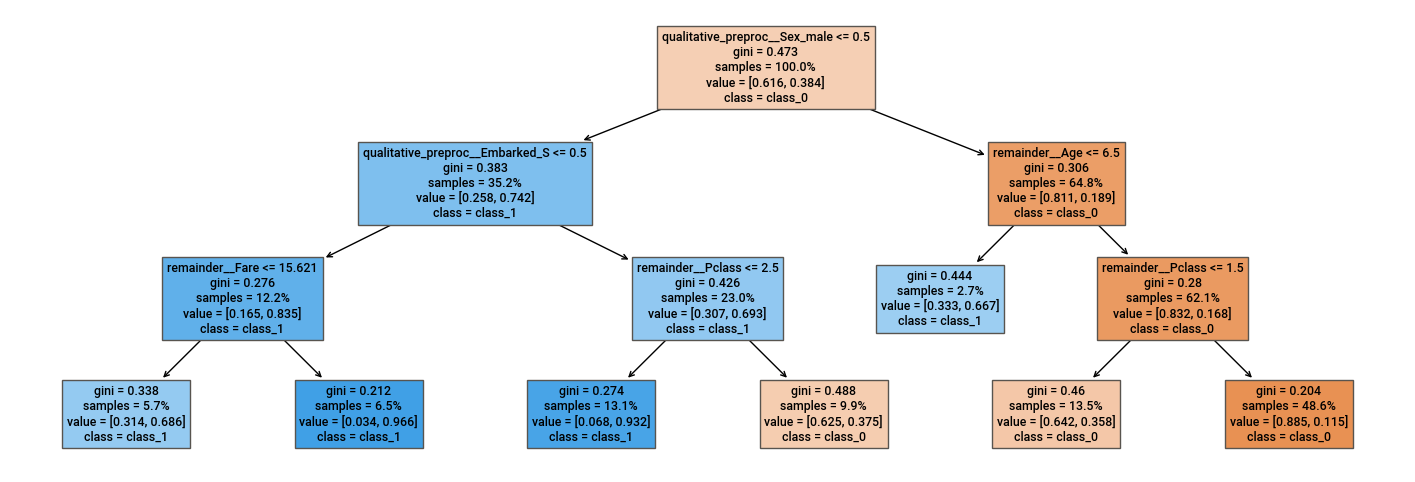

In [20]:
# Get the best estimator from the grid search
best_dt = grid_search.best_estimator_.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(18,6))  # Adjust the figure size as needed
plot_tree(best_dt, 
          feature_names=grid_search.best_estimator_.named_steps.preprocessor.get_feature_names_out(), 
          class_names=['class_0', 'class_1'], 
          filled=True,
          proportion=True,)
plt.show()

**Let’s understand how they make predictions:**

You start from top to bottom, at the root node (depth 0, at the top): this node asks if the value of the *Sex_male* variable is less than or equal to 0.5. If so, go down to the left child node (depth 1, the left). Then this child node, at depth 1, will ask another question (*Embarked_S* <= 0.5?) If so, go to the left and if not, to the right and so on, until it reaches a leaf node (i.e. has no child nodes) and then just look at the predicted class for that respective node.

**Let's now talk about what each of these values ​​present in each node want to tell us:**

* The *samples* attribute of a node calculates the number of instances in the dataset to which it applies. For example, 35.2% instances have the value of the *Embarked_S* variable less than or equal to 0.5 and 64.8% greater than 0.5;

* The value attribute of a node informs the number of training instances of each class to which this node applies: for example, the right node of depth 1, 81.1% of instances apply to the predicted class equal to 0 (no survived) and 18.9% apply to the predicted class equal to 1 (survived);

* The gini attribute of a node calculates its impurity: a node is "pure" if gini is equal to 0, that is, if all training instances to which it applies belong to the same class. for example, the right node of depth 1 has *gini=0.383* this value is calculated by *gini=(0.258² + 0.742²) = 0.383*.

**Notes: This is how the tree makes the decisions.**

* The number of samples per node decreases as we go along the nodes.
* Value is the number/fraction of observations that died or survived.
* Value in the leaves is the prediction of the decision tree (one for each class).
* The decision tree outputs discrete predictions.
* The prediction is the mean target value at each node.

### Feature importance

Weighted decrease in impurity at each node contributed by each feature (normalized to 1, that is, the sum of the importances = 1)

importances[node.feature] += (
    node.weighted_n_node_samples * node.impurity -
    left.weighted_n_node_samples * left.impurity -
    right.weighted_n_node_samples * right.impurity)
node += 1

In [21]:
# The sum of the importances = 1
pd.Series(best_dt.feature_importances_).sum()

1.0

In [22]:
global_exp = pd.Series(best_dt.feature_importances_, index=grid_search.best_estimator_.named_steps.preprocessor.get_feature_names_out())
global_exp

qualitative_preproc__Embarked_Q    0.000000
qualitative_preproc__Embarked_S    0.017702
qualitative_preproc__Sex_male      0.765548
remainder__Pclass                  0.143402
remainder__Age                     0.070335
remainder__SibSp                   0.000000
remainder__Parch                   0.000000
remainder__Fare                    0.003014
dtype: float64

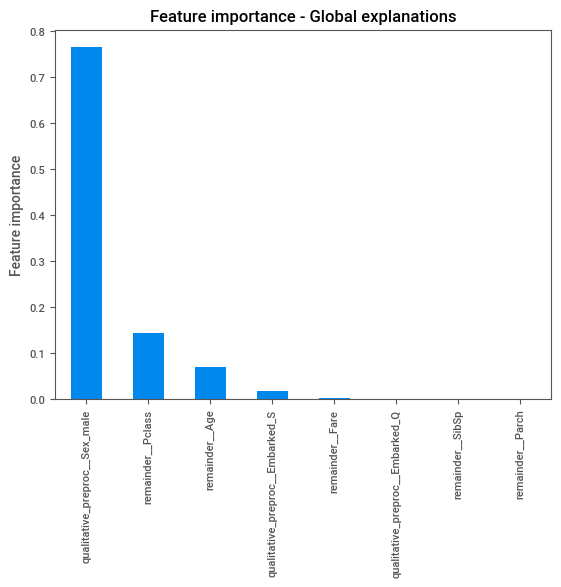

In [23]:
global_exp = pd.Series(best_dt.feature_importances_, index=grid_search.best_estimator_.named_steps.preprocessor.get_feature_names_out())

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

As we can see, only a few variables are actually adding more importance to the model. Let's make the model simpler and more interpretative by removing the variables that are not adding much value.

## Re-train the decision tree

Based on the exploratory analysis and the importance of the trained model's variables, we will select only the most important variables to analyze the results and create a simpler and easier model to interpret. We also gonna test a new feature engineering with the name of the passengers.

In [24]:
# select qualitative features
qualitative_features_enconding = [
    'Sex',
    'Embarked'
]

qualitative_binary_passthrough = [
    'Pclass'
]

quantitative_features = [
    'Age',
    'Fare'
]

features_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin',
    'Embarked',
    'SibSp',
    'Parch',
    'Embarked'
]

qualitative_preproc = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore'))

drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

preprocessor2 = ColumnTransformer([
    ('features_to_drop', drop_features_preproc, features_to_drop),
    ('qualitative_preproc', qualitative_preproc, qualitative_features_enconding)],
    remainder='passthrough')

In [25]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model2 = Pipeline(
    steps=[
        ('preprocessor2', preprocessor2), 
        ('dt2', DecisionTreeClassifier(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'dt2__max_depth': [1, 2, 3],
    # 'dt__max_features': [1, 2, 3, 4, 5, 6, 7, 8, None],
    'dt2__max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search2 = GridSearchCV(final_model2, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search2.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search2.best_params_)

The best hyperparameters were: {'dt2__max_depth': 3, 'dt2__max_leaf_nodes': None}


In [26]:
cvres2 = grid_search2.cv_results_
cvres2 = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres2['mean_test_score'],
                                        cvres2['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres2[0])

The mean test score and mean train score is, respectively: (0.8103132257862031, 0.8201467135225429)


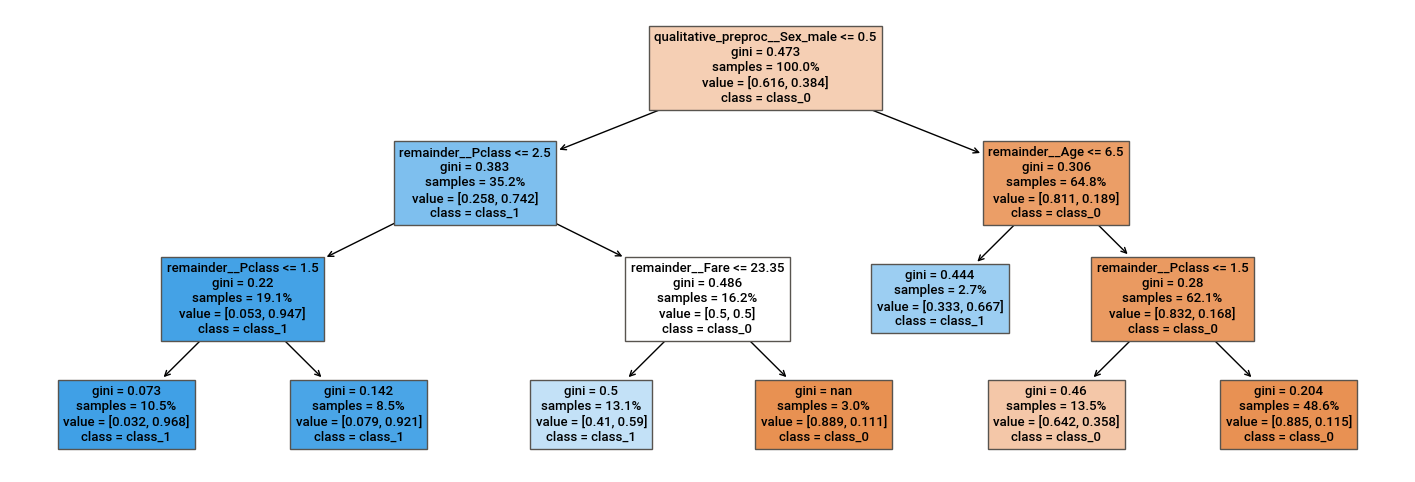

In [27]:
# Get the best estimator from the grid search
best_dt2 = grid_search2.best_estimator_.named_steps['dt2']

# Plot the decision tree
plt.figure(figsize=(18,6))  # Adjust the figure size as needed
plot_tree(best_dt2, 
          feature_names=grid_search2.best_estimator_.named_steps.preprocessor2.get_feature_names_out(), 
          class_names=['class_0', 'class_1'], 
          filled=True,
          proportion=True,)
plt.show()

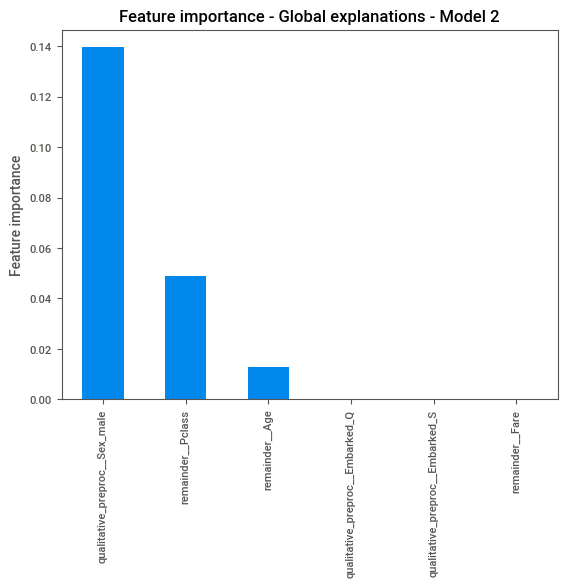

In [28]:
global_exp2 = pd.Series(best_dt2.feature_importances_, index=grid_search2.best_estimator_.named_steps.preprocessor2.get_feature_names_out())

global_exp2.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations - Model 2")
plt.show()

You see, by retraining the model by eliminating 2 variables that were not contributing to the results, we achieved the same results with a simpler model with fewer variables.

## Local Interpretation

Let's now interpret just the result of one instance.

In [29]:
# Display a few observations from test set
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
# pick one observation
sample_id = 4
test_set.loc[sample_id]

PassengerId                                             896
Pclass                                                    3
Name           Hirvonen, Mrs. Alexander (Helga E Lindqvist)
Sex                                                  female
Age                                                    22.0
SibSp                                                     1
Parch                                                     1
Ticket                                              3101298
Fare                                                12.2875
Cabin                                                   NaN
Embarked                                                  S
Name: 4, dtype: object

With the values ​​of the respective instance, you can go to the final model tree that we plotted above and see whether it will survive or not and why the model made this decision.

In [31]:
# calculate the predictions for instance 4
pred = grid_search2.best_estimator_.predict(test_set.loc[[4]])
print('The prediction for this instance is:', pred)

pred_proba = grid_search2.best_estimator_.predict_proba(test_set.loc[[4]])
print('The probabilities for this instance is:', pred_proba)

The prediction for this instance is: [1]
The probabilities for this instance is: [[0.41025641 0.58974359]]


As expected, the model predicted that this person survived. If you go to the plotted tree, you will get this same result, obviously!

### Node contribuitions

In [44]:
first_split = 0.742 - 0.384
second_split = 0.5 - 0.742
third_split = 0.59 - 0.5

first_split, second_split, third_split

(0.358, -0.242, 0.08999999999999997)

As we can see, the first node contributes positively to survival, the second negatively and the third positively.

In [45]:
# prediction
y.mean() + first_split + second_split + third_split

0.5898383838383837

### Feature contribuition

In [46]:
sex = first_split
pclass = second_split
fare = third_split

sex, pclass, fare

(0.358, -0.242, 0.08999999999999997)

In this view we can see the weight that each variable involved gives in the final prediction.

In [48]:
# prediction
y.mean() + sex + pclass + fare

0.5898383838383837

In [49]:
grid_search2.best_estimator_.predict_proba(test_set.loc[sample_id].to_frame().T)

array([[0.41025641, 0.58974359]])

### Tree interpreter

Instead of doing all these calculations above, we can use this library ready for interpretation. It's up to you which one to use or use both to corroborate a result!

[Documentation](https://github.com/andosa/treeinterpreter)

In [37]:
# Supondo que 'X_train' seja seu conjunto de dados de treinamento
X_train_processed = preprocessor2.fit_transform(X)

# Supondo que 'X_test' seja seu conjunto de dados de teste
X_test_processed = preprocessor2.transform(test_set)

In [38]:
prediction, bias, contributions = ti.predict(best_dt2, X_test_processed)

In [39]:
prediction[4]

array([0.41025641, 0.58974359])

In [40]:
test_set.reset_index(drop=True, inplace=True)
test_set.loc[4]

PassengerId                                             896
Pclass                                                    3
Name           Hirvonen, Mrs. Alexander (Helga E Lindqvist)
Sex                                                  female
Age                                                    22.0
SibSp                                                     1
Parch                                                     1
Ticket                                              3101298
Fare                                                12.2875
Cabin                                                   NaN
Embarked                                                  S
Name: 4, dtype: object

In [41]:
# constribution for first sample
contributions[4]

array([[-0.35819983,  0.35819983],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.24203822, -0.24203822],
       [ 0.        ,  0.        ],
       [-0.08974359,  0.08974359]])

In [42]:
# contribution for class = 1
contributions[4][:, 1]

array([ 0.35819983,  0.        ,  0.        , -0.24203822,  0.        ,
        0.08974359])

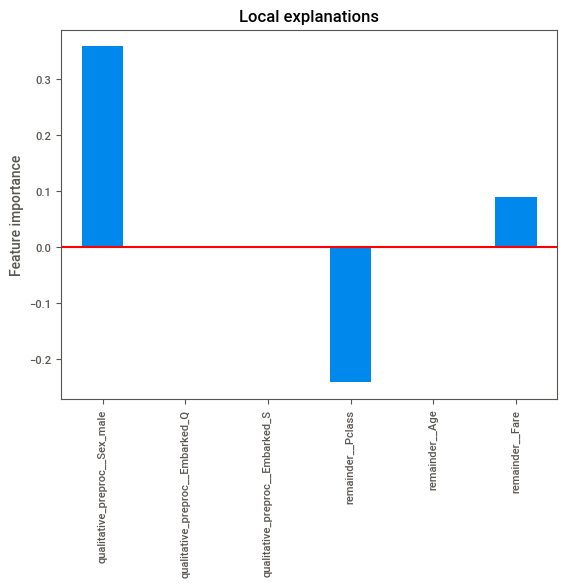

In [43]:
pd.Series(contributions[4][:, 1], index=grid_search2.best_estimator_.named_steps.preprocessor2.get_feature_names_out()).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

Because it is a woman, the *sex_male* variable is contributing to the increase in survival and because it is from the 3rd class, the *Pclass* variable is contributing to the decrease in the chances of survival, which is why the *predict_proba* method is showing probabilities so close to survival and not survival.

## Conclusion

Here I want to summarize the main advandages of the decision trees models and also some of the limitations.

**Advantages**

* Simple model
* Easy to interpret
* Powerful for non-linear associations between features and targets
* Require little data preparation

**Limitations**

* Predictions are not continuous, but piecewise constant approximations
* Not good at extrapolation
* Unstable: changing training data may lead to a different tree and maybe give to you a different interpretation

**Global vs local explainability**

* Global explainability: derived from the loss function
* Local explainability: given by the contribution of each feature to the final output

**Multicolinearity**

* Multicolinearity will mask the importance of the features
* If 2 features are identical, one will be selected and the other one ignored
* Partially collinear features will show reduced importance compared to the importance derived from a model without it's collinear counterparts

**Credits**

https://www.trainindata.com/